# Simulating membrane potential

<div class="topic alert alert-block alert-info">
<b>Topics</b>: Channels, Complexes, Voltage-dependant reactions.
</div>

In this chapter, we will model and simulate action protential propagation along a simplified axon. We will learn how to declare voltage-gated channels and voltage-dependent reactions. As in [the API_1 corresponding chapter](../memb_pot.ipynb), we will use a Markov gating scheme version of the Hodgkin-Huxley (HH) model.

We first import the required modules and specify the values of the parameters that will be used in the model declaration:

In [1]:
import steps.interface

from steps.model import *
from steps.geom import *
from steps.sim import *
from steps.saving import *
from steps.rng import *

import numpy as np
import math

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #  
# # # # # # # # # # # # # # # # # # PARAMETERS  # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# # # # # # # # # # # # # # # # # # CHANNELS  # # # # # # # # # # # # # # # # # #

# Potassium conductance = 0.036 S/cm2
# Sodium conductance = 0.120 S/cm2

# Potassium single-channel conductance
K_G = 20.0e-12 # Siemens

# Potassium channel density
K_ro = 18.0e12 # per square meter

# Potassium reversal potential
K_rev = -77e-3 # volts

# Sodium single-channel conductance
Na_G = 20.0e-12 # Siemens

# Sodium channel density
Na_ro = 60.0e12 # per square meter

# Sodium reversal potential
Na_rev = 50e-3 # volts

# Leak single-channel conductance
L_G = 0.3e-12 # Siemens

# Leak density
L_ro = 10.0e12 # per square meter

# Leak reveral potential
leak_rev = -54.4e-3 # volts


# A table of potassium channel population factors: 
# n0, n1, n2, n3, n4
K_facs = [ 0.21768, 0.40513, 0.28093, 0.08647, 0.00979 ]

# A table of sodium channel population factors
# m0h0, m1h0, m2h0, m3h0, m0h1, m1h1, m2h1, m3h1:
Na_facs = [[0.34412, 0.05733, 0.00327, 6.0e-05],
           [0.50558, 0.08504, 0.00449, 0.00010]]

# # # # # # # # # # # # # # # # # # MESH  # # # # # # # # # # # # # # # # # # # # 

meshPath = 'meshes/axon.inp'

# # # # # # # # # # # # # # # SIMULATION CONTROLS # # # # # # # # # # # # # # # #

# Temperature for gating kinetics
celsius = 20.0

# Current injection
Iclamp = 50.0e-12 #	amps

# Voltage range for gating kinetics in Volts
Vrange = [-100.0e-3, 50e-3, 1e-4]

# The simulation dt
DT_sim = 1.0e-4 # seconds

# The time until which the simulation should be run
ENDT = 4.0e-3

## Model declaration

Both potassium and sodium channels are described with a markov chain and, while we could describe each state explicitely, we will instead take advantage of the fact that the `Channel` class inherits from `Complex`. This will simplify the declaration of voltage dependent reactions. We thus need to declare `SubUnit` and `SubUnitState` elements, like in the [multi-state complexes chapter](Interface_Tutorial_4_Complexes.ipynb). 

### Channel declaration

As a reminder, the markov chains for both channels are represented in the following figure:

<img src="images/channels_states.png"/>

Below the markov chains, we represented the full reaction networks when considering that the channels are made up of 4 subunits: 4 identical subunits that can be in closed ('c', light blue) or open ('o', dark blue) states for the K+ channel; 3 identical subunits that can be in closed (c, light orange) or open ('o', dark orange) states as well as one subunit that can be in inactivated ('i', light green) or activated ('a', dark green) states.
The markov chains from the top row are resulting from the grouping of equivalent channel substates. For the K+ channel, state n0 in the markov chain corresponds to only one channel state in which all subunits are in closed state; there are thus 4 ways to go to state n1 in which one of the subunits becomes open, and this is why the markov transition from n0 to n1 is done with a $4a_n$ rate.
The full reaction networks directly result from the application of the reactions over single subunits represented in the bottom row of the figure. K+ subunits can switch between closed and open states with respective rates $a_n$ and $b_n$. The same type of reactions apply to Na+ 'm' and 'h' subunits.

Instead of declaring all the reactions from the markov chain, we can thus use the fact that `Channel` is a subclass of `Complex` to only declare the subunit reactions from the bottom row of the figure. STEPS will automatically compute the required channel states and apply the required coefficients for the reaction rates. We then proceed to declaring the `Channel`s, their associated `SubUnit`s and `SubUnitState`s:

In [2]:
model = Model()

r = ReactionManager()

with model:
    ssys = SurfaceSystem.Create()

    #  Potassium channel
    Ko, Kc = SubUnitState.Create()
    KSU = SubUnit.Create([Ko, Kc])
    VGKC = Channel.Create([KSU]*4)

    # Sodium channel
    Na_mo, Na_mc, Na_hi, Na_ha = SubUnitState.Create()
    NamSU, NahSU = SubUnit.Create(
        [Na_mo, Na_mc],
        [Na_hi, Na_ha]
    )
    VGNaC = Channel.Create([NamSU, NamSU, NamSU, NahSU])

    # Leak channel
    lsus = SubUnitState.Create()
    Leak = Channel.Create([lsus])

The leak channel can only be in a single state but still needs to have an associated `SubUnitState`. It is however possible to skip declaring a `SubUnit` by giving the `SubUnitState` directly to the `Channel` constructor. Note that we declared a surface system since voltage dependent reactions are going to happen on the cell membrane. 

### Voltage dependent reactions declaration

We then declare all reactions with:

In [3]:
with model:
    thi = math.pow(3.0, ((celsius-6.3)/10.0)) * 1.0e3

    _a_n = VDepRate(lambda V: thi*((0.01*(10-(V*1e3+65))/(math.exp((10-(V*1e3+65))/10)-1))), vrange=Vrange)
    _b_n = VDepRate(lambda V: thi*((0.125*math.exp(-(V*1e3+65)/80))), vrange=Vrange)
    
    _a_m = VDepRate(lambda V: thi*((0.1*(25-(V*1e3+65))/(math.exp((25-(V*1e3+65))/10)-1))), vrange=Vrange)
    _b_m = VDepRate(lambda V: thi*((4*math.exp(-(V*1e3+65)/18))), vrange=Vrange)

    _a_h = VDepRate(lambda V: thi*((0.07*math.exp(-(V*1e3+65)/20))), vrange=Vrange)
    _b_h = VDepRate(lambda V: thi*((1/(math.exp((30-(V*1e3+65))/10)+1))), vrange=Vrange)

    with ssys:

        with VGKC[...]:
            Kc.s <r[1]> Ko.s
            r[1].setRates(_a_n, _b_n)

        with VGNaC[...]:
            Na_hi.s <r[1]> Na_ha.s
            r[1].setRates(_a_h, _b_h)
            
            Na_mc.s <r[1]> Na_mo.s
            r[1].setRates(_a_m, _b_m)

        VGKC_I = OhmicCurr.Create(VGKC[Ko, Ko, Ko, Ko], K_G, K_rev)
        VGNaC_I = OhmicCurr.Create(VGNaC[Na_mo, Na_mo, Na_mo, Na_ha], Na_G, Na_rev)
        Leak_I = OhmicCurr.Create(Leak[lsus], L_G, leak_rev)

We first declare voltage dependent rates with the `VDepRate` class. Its constructor takes a function as first parameter and an optional voltage range (with the `vrange` parameter). The function must take a voltage in Volts as a parameter and return a reaction rate. Here the rates correspond to the classical HH rates. Note that if we decided to declare n0, n1, etc. states explicitely, we could have declared reactions in the following way:

```python
...
n0.s <r[1]> n1.s
r[1].setRates(4*_a_n, _b_n)
...
```
We would not need to declare a new `VDepRate` object, we can simply directly multiply the existing one with the appropriate coefficient.

Note that, since we are declaring reactions between `SubUnitState`s, we first need to specify the `Channel` to which these reactions apply and the state in which this channel must be for the reaction to apply. Since our reactions always apply regardless of the channel state we use e.g.:
```python
with VGKC[...]:
    Kc.s <r[1]> Ko.s
    r[1].setRates(_a_n, _b_n)
```
Since the reaction happens on the membrane, we need to specify the Channel position by adding the `.s` after the `SubUnitState`. If the state of the channel affected the voltage dependency of the reaction rates, we could have written:
```python
with VGKC[Ko, Ko, ...]:
    Kc.s <r[1]> Ko.s
    r[1].setRates(_a_n_2, _b_n_2)
```
With this code, we only declare reactions for channels that have at least two subunits in the open state, and we use a different reaction rate.

### Current declaration

Finally, we declared the ohmic currents associated to the 3 channels. We use the `OhmicCurr` constructor that takes a description of the open state(s) as first parameter, a conductance, and a reversal potential. For example, we declared the K+ current like this:
```python
VGKC_I = OhmicCurr.Create(VGKC[Ko, Ko, Ko, Ko], K_G, K_rev)
```
`VGKC[Ko, Ko, Ko, Ko]` reprensents the K+ channel state in which all 4 subunits are in the open state. Note that it is possible to give a partially specified channel state as first parameter of the current constructor. For example, if we wanted to consider that the K+ channel is open if at least 3 subunits are in the open state, we could have written:
```python
VGKC_I = OhmicCurr.Create(VGKC[Ko, Ko, Ko, :], K_G, K_rev)
```
Note that, since all subunits are identical for the K+ channel, the position of the `:` does not matter as `Channel`s do not take `SubUnit` order into account by default, see the [documentation](API_model.rst#steps.API_2.model.Complex) for details.

#### State dependent conductances

Instead of giving a constant conductance, as we did in the main example, we could give a conductance that depends on the channel state:
```python
...
K_conds = [0, 0.05*K_G, 0.1*K_G, 0.5*K_G, K_G]
K_depG = CompDepCond(lambda s: K_conds[s.Count(Ko)], [VGKC])

VGKC_I = OhmicCurr.Create(VGKC[Ko, ...], K_depG, K_rev)
```
We declare a `Complex` dependent conductance with the`CompDepCond` constructor. The first parameter is a function that takes a `ComplexState` as argument and outputs a conductance; the second argument is a list of complexes (channels here) that specifies on which complexes will the conductance depend. Here we only depend on the state of the K+ channel. 

In the lambda function, we call the `Count` method on the channel state `s` in order to count the number of subunits that are in open state `Ko`, we then use this number to find the corresponding conductance in a small list that we declared just before: 1 open subunit corresponds to 5% of the maximum conductance, 2 open to 10%, 3 open to 50% and 4 open to the maximum conductance. 

The current is then created by specifying that it applies to all K+ channel states that have at least one open subunit. We could have applied it to all states but it would result in null currents since the conductance associated to all subunits being closed is 0. Note that when the first parameter of the current constructor corresponds to more than one channel state, several subcurrents are created and associated to the same current name (`'VGKC_I'` here). When saving data, these subcurrents can be accessed by specifying the state of the channel they correspond to, as we will see later.

#### GHK currents

Although we do not use GHK currents in the main example, we will quickly go over how to declare them. Assuming we want to declare a GHK Na+ current, we would have to write:
```python
with mdl:
    Na = Species.Create()
    Na.valence = 1
    
    with ssys:
        VGNaC_I = GHKCurr.Create(VGNaC[Na_mo, Na_mo, Na_mo, Na_ha], Na, VGNaC_P)
```
The current is created with the `GHKCurr` class that takes the conducting state(s) as first parameter, like for `OhmicCurr`, but then takes the ion for which the current is defined followed by the permeability of the channel (`VGNaC_P` here).
Note that this permeability can be obtained with the `GHKCurr.PInfo` [class method](API_model.rst#steps.API_2.model.GHKCurr.PInfo).

Like for conductances, it is possible to define state-dependent permeabilities:
```python
Na_perm = [0, 0.05*VGNaC_P, 0.5*VGNaC_P, VGNaC_P]
Na_depP = CompDepP(lambda s: Na_perm[s.Count(Na_mo)], [VGNaC])
VGNaC_I = GHKCurr.Create(VGNaC[Na_mo, ..., Na_ha], Na, Na_depP)
```
More details can be found in the `GHKCurr` [documentation](API_model.rst#steps.API_2.model.GHKCurr).

## Geometry declaration

Coming back to our main example, we now load the mesh from an Abaqus file and compute some element lists:

In [4]:
mesh = TetMesh.LoadAbaqus(meshPath, scale=1e-6)

facetris = TriList(tri for tri in mesh.tris if tri.center.z == mesh.bbox.min.z)
injverts = facetris.verts

memb_tris = mesh.surface - facetris

# The points along (z) axis at which to record potential
pot_pos = np.arange(mesh.bbox.min.z, mesh.bbox.max.z, 10e-6)
pot_tet = TetList(mesh.tets[0, 0, z] for z in pot_pos)

We first create a list (`facetris`) of the triangles that are on one of the ends of the axon (that is oriented along the z-axis) and extract the corresponding vertices with `facetris.verts`. We will use these vertices to inject current in the axon. The triangles in the membrane are all triangles in the mesh surface except the ones that are on the injection face. Finally, we declare a list of regularly spaced tetrahedrons along the axon that we will record potential from.

We then declare the needed compartment, patch, and membrane for potential computation:

In [5]:
with mesh:
    cyto = TetComp.Create(mesh.tets)
    patch = TetPatch.Create(memb_tris, cyto, None, ssys)

    # Create the membrane across which the potential will be solved
    membrane = Membrane.Create([patch])

The membrane is created with the `Membrane` class; its constructor takes a list of patches as first argument. Additional parameters are described in the [documentation](API_geom.rst#steps.API_2.geom.Membrane).

## Simulation and data saving

We will use the `'Tetexact'` solver and save the K+ and Na+ currents across the membrane as well as the potential at the regularly spaced tetrahedrons we mentioned before:

In [6]:
rng = RNG('mt19937', 512, 1234)

sim = Simulation('Tetexact', model, mesh, rng, True)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

rs = ResultSelector(sim)

NaCurrs = rs.TRIS(memb_tris).VGNaC_I.I
KCurrs = rs.TRIS(memb_tris).VGKC_I.I
CellPot = rs.TETS(pot_tet).V

NaCurrs.metaData['trizpos'] = [tri.center.z for tri in memb_tris]
KCurrs.metaData['trizpos'] = [tri.center.z for tri in memb_tris]

NaCurrs.metaData['triarea'] = [tri.Area for tri in memb_tris]
KCurrs.metaData['triarea'] = [tri.Area for tri in memb_tris]

CellPot.metaData['tetzpos'] = pot_pos

NaCurrs.toFile('NaCurrs.dat')
KCurrs.toFile('KCurrs.dat')
CellPot.toFile('CellPot.dat')

sim.toSave(NaCurrs, KCurrs, CellPot, dt=DT_sim)

Model checking:
No errors were found


Note that we pass an additional boolean flag to the `Simulation` constructor, it specifies whether membrane potential calculations should be performed. This flag defaults to `False` so we could omit it in previous chapters, but since we do need membrane potential computations, we need to set it to `True`.

Since the `VGNaC_I` and `VGKC_I` currents are both associated to a single channel state, the `NaCurrs` and `KCurrs` result selectors will save the current corresponding to this state for each triangle in `memb_tris`. If the currents were associated to several channel states, these same result selectors would save the sum of each subcurrent for each triangle. If one wanted to access a specific subcurrent one would write:
```python
rs.TRIS(memb_tris).VGKC_I[Ko, Ko, Ko, Kc].I
```
This result selector would only save the cubcurrent associated to K+ channels with 3 open subunits and one closed. In the same way, it is also possible to save the summed currents associated to several channel states:
```python
rs.TRIS(memb_tris).VGKC_I[Ko, Ko, ...].I
```
This would save the summed currents through all K+ channels that have at least two subunits in the open state. Finally, if one wants to save separately each subcurrent, one can write e.g.:
```python
rs.patch.LIST(*VGKC_I).I
```
Iterating over the `VGKC_I` current object returns the sub currents it is composed of.

Since we want to plot spatial current density profiles, we need to save the z position and area of membrane triangles as metadata. In the same way, we need to save the z position of the tetrahedrons from which we will record potential.
Finally, all our result selectors will be saved to files in order to separate data analysis from the simulation script.

We then proceed to setting the initial state and running the simulation:

In [7]:
sim.newRun()

# Inject channels
surfarea = sim.patch.Area

for state in VGNaC:
    prop = Na_facs[state.Count(Na_ha)][state.Count(Na_mo)]
    sim.patch.VGNaC[state].Count = Na_ro * surfarea * prop

for state in VGKC:
    prop = K_facs[state.Count(Ko)]
    sim.patch.VGKC[state].Count = K_ro * surfarea * prop

sim.patch.Leak[lsus].Count = L_ro * surfarea

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Set some simulation variables:

# Set dt for membrane potential calculation to 0.01ms
sim.EfieldDT = 1.0e-5

# Initialize potential to -65mV
sim.membrane.Potential = -65e-3

# Set capacitance of the membrane to 1 uF/cm^2 = 0.01 F/m^2
sim.membrane.Capac = 1.0e-2

# Set resistivity of the conduction volume to 100 ohm.cm = 1 ohm.meter
sim.membrane.VolRes = 1.0

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# Set the current clamp

sim.VERTS(injverts).IClamp = Iclamp/len(injverts)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Run the simulation
sim.run(ENDT)

Note that we set the count of channels by using the `Na_facs` and `K_facs` arrays that contain the fractions of channels that should be in each state. `K_facs` is sorted such that the first element corresponds to the state in which all subunits are in the closed state and the last element corresponds to all subunits in open state. `Na_facs` contains two arrays, the first one corresponding to the `Na_hSU` subunit in state `Na_hi` and the second one corresponds to state `Na_ha`. The two arrays are organized like `K_facs` but for the `Na_mSU` subunit.

We iterate over all states of e.g. the K+ channel and retrieve its corresponding fraction with:
```python
for state in VGKC:
    prop = K_facs[state.Count(Ko)]
```
where `state.Count(Ko)` returns the number of subunits in state `Ko` that are in the channel `state`.

We then need to set values that are specific to membrane potential calculations. We first set the Efield time step for all the simulation to 0.01 ms; we then set the initial membrane potential as well as the membrane capacity and bulk resistivity of the volume enclosed by the membrane.

We then add a current clamp on the vertices at one end of the axon with the `IClamp` property. We want a total injected current of `Iclamp` so we divide this value by the number of vertices in the `injverts` list. Note that current clamps can also be added to triangles of the membrane.

The other initial conditions are relatively straightforward, we then run the simulation with `sim.run(ENDT)`. Before proceeding to result plotting, we reset the jupyter notebook so that the remaining code will be executed as if it was run in a separate script:

In [8]:
%reset -f

## Plotting the results

We first import the required modules and load the result selectors from file:

In [9]:
import steps.interface

from steps.saving import *

from matplotlib import pyplot as plt
import numpy as np

NaCurrs = ResultSelector.FromFile('NaCurrs.dat')
KCurrs = ResultSelector.FromFile('KCurrs.dat')
CellPot = ResultSelector.FromFile('CellPot.dat')

We then define a function to plot the potential along the axon at a given time index `tidx`:

In [10]:
def plotPotential(tidx):
    plt.plot(
        CellPot.metaData['tetzpos'] * 1e6, 
        CellPot.data[0, tidx, :] * 1e3, 
        label=f'{CellPot.time[0, tidx]*1e3} ms'
    )

And another function to plot both K+ and Na+ current densities through the membrane along the axon:

In [11]:
NBINS = 100
def plotCurrents(tidx):
    for results, currName in zip([NaCurrs, KCurrs], ['Na', 'K']):
        data = results.data[0, tidx, :] * 1e12
        pos = results.metaData['trizpos'] * 1e6
        areas = results.metaData['triarea'] * 1e12
        bins = np.histogram_bin_edges(pos, NBINS)
        dig = np.digitize(pos, bins)
        # Ignore empty bins
        with np.errstate(invalid='ignore'):
            meanData = np.bincount(dig, weights=data) / np.bincount(dig, weights=areas)
            meanPos  = np.bincount(dig, weights=pos) / np.bincount(dig)
        plt.plot(meanPos, meanData, label=f'{currName} {results.time[0, tidx]*1e3} ms')

Since we recorded currents for each membrane triangle, we first need to bin the currents along the axon.
In order to simplify the code, we rely heavily on the numpy functions [histogram_bin_edges](https://numpy.org/doc/stable/reference/generated/numpy.histogram_bin_edges.html), [digitize](https://numpy.org/doc/stable/reference/generated/numpy.digitize.html), and [bincount](https://numpy.org/doc/stable/reference/generated/numpy.bincount.html).
We first create bin edges for the triangle positions with:
```python
bins = np.histogram_bin_edges(pos, NBINS)
```
We then assign each triangle to its bin with:
```python
dig = np.digitize(pos, bins)
```
Finally, we compute current densities and average bin position with:
```python
meanData = np.bincount(dig, weights=data) / np.bincount(dig, weights=areas)
meanPos  = np.bincount(dig, weights=pos) / np.bincount(dig)
```
Note that `np.bincount(dig)` returns the number of triangles in each bin while `np.bincount(dig, weights=areas)` returns the summed areas of triangles in each bin.

Finally, we plot the potential along the axon at different time steps:

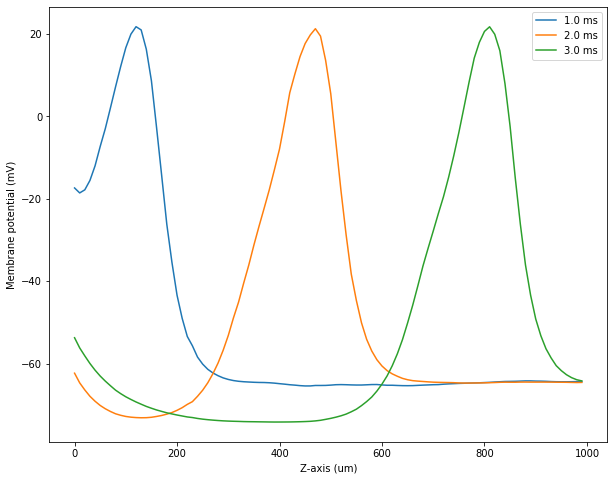

In [12]:
plt.figure(figsize=(10, 8))
plotPotential(10)
plotPotential(20)
plotPotential(30)
plt.xlabel('Z-axis (um)')
plt.ylabel('Membrane potential (mV)')
plt.legend()
plt.show()

We then plot the Na+ and K+ current densities along the axon for the same time steps:

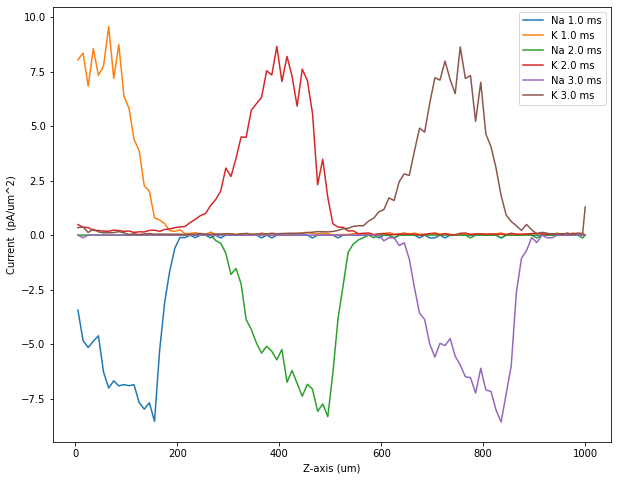

In [13]:
plt.figure(figsize=(10, 8))
plotCurrents(10)
plotCurrents(20)
plotCurrents(30)
plt.xlabel('Z-axis (um)')
plt.ylabel('Current  (pA/um^2)')
plt.legend()
plt.show()